In [2]:
#pip install -r requirements.txt 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation
from IPython.display import HTML # For displaying animation in Jupyter

In [3]:

# --- Configuration Parameters ---
# These would ideally be controllable by ipywidgets

# Mirror 1 (bottom, concave, opens upwards)
F1 = 5.0  # Focal length of mirror 1
M1_CENTER_Y = 0.0
M1_X_LIMIT = 4.0  # Half-width of the mirror

# Mirror 2 (top, concave, opens downwards, shares focus with M1)
# M2 is placed such that rays from M1 hit it before reaching F1.
# Let the common focus be F_COMMON_Y = F1
F_COMMON_Y = F1
# To make M2's focus also F_COMMON_Y, its equation relative to its vertex (D_M2_VERTEX_Y) is y' = -x^2 / (4*f2_val)
# And F_COMMON_Y = D_M2_VERTEX_Y - f2_val
# Let's define M2's vertex y-position
D_M2_VERTEX_Y = F_COMMON_Y * 0.8 # Place M2 vertex before the common focus
F2_VAL = D_M2_VERTEX_Y - F_COMMON_Y # This will be negative, meaning it opens downwards
M2_X_LIMIT = 2.0 # Half-width of mirror 2, chosen to be smaller for compression

# Initial Ray Bundle Parameters
NUM_RAYS = 5  # Number of rays in the bundle
INITIAL_Y = -5.0      # Starting y-position of rays
INITIAL_X_SPREAD = 2.0 # Initial spatial spread (delta_x)
INITIAL_PX_SPREAD = 0.1 # Initial momentum spread (delta_p_x), proportional to angular spread
BEAM_CENTER_X = 0.0

# Animation Parameters
N_FRAMES = 200
PROPAGATION_STEP = 0.1
RECT_SCALE_PX = 20 # Scaling factor for visualizing delta_p_x as height

In [4]:

# --- Helper Functions for Parabola ---
def parabola_eq(x, f, y_offset=0, x_offset=0):
    """Defines y = (x-x_offset)^2 / (4f) + y_offset"""
    return (x - x_offset)**2 / (4 * f) + y_offset

def parabola_deriv(x, f, x_offset=0):
    """Derivative dy/dx for y = (x-x_offset)^2 / (4f) + y_offset"""
    return (x - x_offset) / (2 * f)

def get_parabola_points(f, y_offset, x_limit, num_points=100, x_offset=0):
    x_vals = np.linspace(-x_limit + x_offset, x_limit + x_offset, num_points)
    y_vals = parabola_eq(x_vals, f, y_offset, x_offset)
    return x_vals, y_vals

# --- Ray Class ---
class Ray:
    def __init__(self, origin, direction):
        self.origin = np.array(origin, dtype=float)
        self.direction = np.array(direction, dtype=float) / np.linalg.norm(direction)
        self.path = [self.origin.copy()]
        self.active = True
        self.reflected_m1 = False
        self.reflected_m2 = False
        self.max_y_travel = D_M2_VERTEX_Y + 2.0 # Stop rays beyond M2

    def _get_normal(self, x_intersect, mirror_f, mirror_x_offset, mirror_orientation_sign=1):
        """Calculates normal vector to the parabola at x_intersect."""
        # mirror_orientation_sign: 1 if opens up/right, -1 if opens down/left
        slope = parabola_deriv(x_intersect, mirror_f, mirror_x_offset)
        # Normal vector components: (-dy/dx, 1) or (dy/dx, -1)
        # We want the normal pointing "towards" the incoming ray or "out" of the mirror surface.
        # For y = ax^2, normal can be (-2ax, 1).
        # If mirror opens upwards (f>0), normal points generally upwards.
        # If mirror opens downwards (f<0), normal points generally downwards.
        normal = np.array([-slope, mirror_orientation_sign * 1.0]) # Simplified normal direction
        if mirror_f < 0: # Opens downwards
             normal = np.array([slope, -1.0 * mirror_orientation_sign]) # Ensure it points "into" the mirror from ray side

        # Adjust normal based on ray direction (ensure normal opposes incoming ray somewhat)
        # This part is tricky and needs robust implementation for general cases.
        # For y = (x-xo)^2/(4f) + yo:
        # Tangent slope m = (x-xo)/(2f). Normal slope = -1/m.
        # Normal vector: (1, -1/m) or (-1, 1/m). Normalize.
        # A simpler normal for y=ax^2+c is (-2ax, 1) or (2ax, -1)
        # For M1 (f>0, opens up): normal (-deriv, 1)
        # For M2 (f<0, opens down): normal (deriv, -1) seems more appropriate if deriv defined for positive f
        
        # Let's use the definition: normal to f(x,y)=0 is grad(f)
        # For y - (x-xo)^2/(4f) - yo = 0 => grad = (-2(x-xo)/(4f), 1) = (-(x-xo)/(2f), 1)
        # This normal points in direction of increasing f(x,y).
        # We need it to point "out" of the mirror surface.
        if mirror_f > 0: # M1, opens up, rays from below
            normal = np.array([-slope, 1.0])
        else: # M2, opens down (f is negative), rays from below M2's vertex
            normal = np.array([slope, -1.0]) # dy/dx is (x-xo)/(2*negative_f)

        return normal / np.linalg.norm(normal)


    def reflect(self, normal_vec):
        self.direction = self.direction - 2 * np.dot(self.direction, normal_vec) * normal_vec
        self.path.append(self.origin.copy()) # Add point of reflection

    def propagate(self, step_size):
        if not self.active:
            return

        # Check for intersection with Mirror 1
        if not self.reflected_m1:
            # Simplified intersection: Check if ray is about to cross M1's y-plane
            # A proper intersection would solve line-parabola system
            next_y = self.origin[1] + self.direction[1] * step_size
            m1_y_at_ray_x = parabola_eq(self.origin[0], F1, M1_CENTER_Y)
            
            if self.direction[1] > 0 and self.origin[1] < m1_y_at_ray_x < next_y and abs(self.origin[0]) < M1_X_LIMIT:
                # Approximate intersection point
                self.origin[1] = m1_y_at_ray_x
                self.origin[0] = self.origin[0] # Keep x, update y to be on parabola
                
                normal = self._get_normal(self.origin[0], F1, 0, 1)
                self.reflect(normal)
                self.reflected_m1 = True
                return

        # Check for intersection with Mirror 2
        elif self.reflected_m1 and not self.reflected_m2:
            next_y = self.origin[1] + self.direction[1] * step_size
            m2_y_at_ray_x = parabola_eq(self.origin[0], F2_VAL, D_M2_VERTEX_Y) # F2_VAL is negative

            # Rays are likely moving towards M2 (direction[1] could be >0 or <0 depending on F1)
            # M2 is "above" M1, but rays converge then hit M2 from "below" M2's vertex
            if self.origin[1] < m2_y_at_ray_x < next_y and abs(self.origin[0]) < M2_X_LIMIT and self.direction[1] > 0: # Hitting M2 from below
                 self.origin[1] = m2_y_at_ray_x
                 normal = self._get_normal(self.origin[0], F2_VAL, 0, -1) # F2_VAL is negative
                 self.reflect(normal)
                 self.reflected_m2 = True
                 return
            elif self.direction[1] < 0 and self.origin[1] > m2_y_at_ray_x > next_y and abs(self.origin[0]) < M2_X_LIMIT: # Also possible if M2 is far and rays go past focus
                 self.origin[1] = m2_y_at_ray_x
                 normal = self._get_normal(self.origin[0], F2_VAL, 0, -1)
                 self.reflect(normal)
                 self.reflected_m2 = True
                 return


        # Normal propagation
        self.origin += self.direction * step_size
        self.path.append(self.origin.copy())

        if self.origin[1] > self.max_y_travel or self.origin[1] < INITIAL_Y - 2.0:
            self.active = False

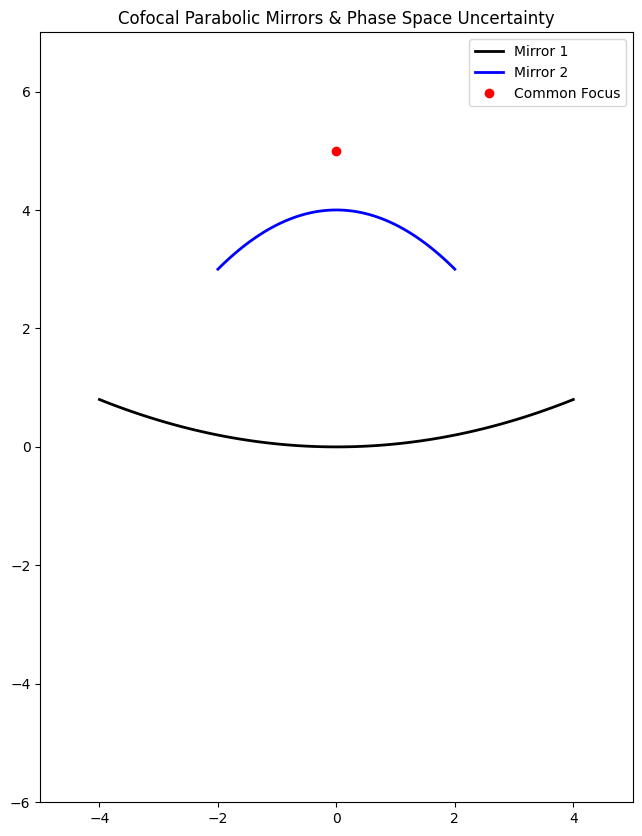

In [5]:
            
# --- Setup Plot ---
fig, ax = plt.subplots(figsize=(8, 10))
ax.set_aspect('equal')
ax.set_xlim(-M1_X_LIMIT -1, M1_X_LIMIT + 1)
ax.set_ylim(INITIAL_Y -1 , D_M2_VERTEX_Y + 3)
ax.set_title("Cofocal Parabolic Mirrors & Phase Space Uncertainty")

# Plot Mirrors
m1_x, m1_y = get_parabola_points(F1, M1_CENTER_Y, M1_X_LIMIT)
ax.plot(m1_x, m1_y, 'k-', lw=2, label="Mirror 1")

m2_x, m2_y = get_parabola_points(F2_VAL, D_M2_VERTEX_Y, M2_X_LIMIT) # F2_VAL is negative
ax.plot(m2_x, m2_y, 'b-', lw=2, label="Mirror 2")

# Plot common focus (for reference)
# Common focus is at (0, F_COMMON_Y)
ax.plot(0, F_COMMON_Y, 'ro', label="Common Focus")
ax.legend()

# Initialize Rays
rays = []
initial_xs = np.linspace(BEAM_CENTER_X - INITIAL_X_SPREAD / 2, BEAM_CENTER_X + INITIAL_X_SPREAD / 2, NUM_RAYS)
initial_angles = np.arctan(np.linspace(-INITIAL_PX_SPREAD / 2, INITIAL_PX_SPREAD / 2, NUM_RAYS)) # px ~ p_total * angle

for i in range(NUM_RAYS):
    angle = initial_angles[i]
    direction = [np.sin(angle), np.cos(angle)] # Assuming propagation mainly along y
    rays.append(Ray([initial_xs[i], INITIAL_Y], direction))

ray_lines = [ax.plot([], [], color='gray', alpha=0.5)[0] for _ in range(NUM_RAYS)]

# Phase Space Rectangle
# We'll draw this at the average y-position of the active ray origins
phase_rect_patch = patches.Rectangle((0, 0), 0, 0, fc='red', alpha=0.3)
ax.add_patch(phase_rect_patch)

# --- Animation Functions ---
def init():
    for line in ray_lines:
        line.set_data([], [])
    phase_rect_patch.set_width(0)
    phase_rect_patch.set_height(0)
    return ray_lines + [phase_rect_patch]

def update(frame):
    current_ray_origins_x = []
    current_ray_origins_y = []
    current_ray_angles_rad = [] # Store angles relative to y-axis

    active_rays_count = 0
    for i, ray in enumerate(rays):
        if ray.active:
            ray.propagate(PROPAGATION_STEP)
            path_arr = np.array(ray.path)
            ray_lines[i].set_data(path_arr[:, 0], path_arr[:, 1])
            
            current_ray_origins_x.append(ray.origin[0])
            current_ray_origins_y.append(ray.origin[1])
            # Angle with positive y-axis: arctan2(dx, dy)
            current_ray_angles_rad.append(np.arctan2(ray.direction[0], ray.direction[1]))
            active_rays_count +=1

    if active_rays_count > 1:
        min_x, max_x = np.min(current_ray_origins_x), np.max(current_ray_origins_x)
        avg_x = np.mean(current_ray_origins_x)
        avg_y = np.mean(current_ray_origins_y) # Position rectangle at average y of current ray fronts

        delta_x = max_x - min_x
        
        min_angle, max_angle = np.min(current_ray_angles_rad), np.max(current_ray_angles_rad)
        delta_angle = max_angle - min_angle # This is our delta_theta ~ delta_px

        phase_rect_patch.set_xy((avg_x - delta_x / 2, avg_y - (delta_angle * RECT_SCALE_PX)/2 )) # Center the height visual
        phase_rect_patch.set_width(delta_x)
        phase_rect_patch.set_height(delta_angle * RECT_SCALE_PX) # Scale for visibility

        # Print for debugging
        if frame % 20 == 0:
             print(f"Frame {frame}: delta_x={delta_x:.2f}, delta_angle={delta_angle:.3f}, Area_proxy={delta_x*delta_angle:.4f}")
    elif active_rays_count == 1 and current_ray_origins_x: # Handle single ray case for rectangle
        phase_rect_patch.set_xy((current_ray_origins_x[0], current_ray_origins_y[0]))
        phase_rect_patch.set_width(0.01) # Minimal width/height
        phase_rect_patch.set_height(0.01)


    return ray_lines + [phase_rect_patch]


Frame 0: delta_x=2.01, delta_angle=0.100, Area_proxy=0.2008
Frame 20: delta_x=2.21, delta_angle=0.100, Area_proxy=0.2208
Frame 40: delta_x=2.41, delta_angle=0.100, Area_proxy=0.2407
Frame 60: delta_x=3.09, delta_angle=6.133, Area_proxy=18.9383
Frame 80: delta_x=4.26, delta_angle=6.133, Area_proxy=26.1558
Frame 100: delta_x=5.44, delta_angle=6.133, Area_proxy=33.3733
Frame 120: delta_x=6.62, delta_angle=6.133, Area_proxy=40.5907


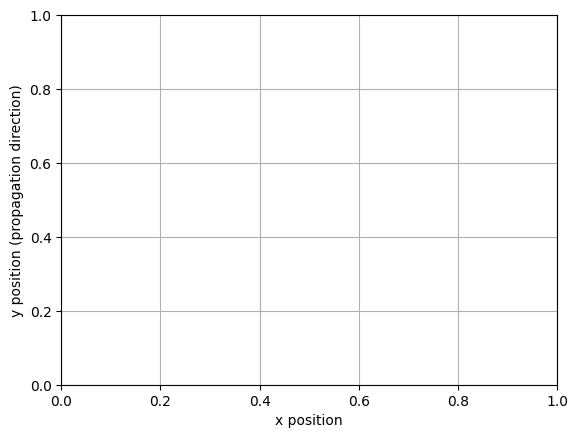

To run the animation, uncomment the anim = ... and HTML(...) lines.
The current ray tracing and reflection logic is a simplified approximation.
Key parameters to adjust: F1, D_M2_VERTEX_Y, INITIAL_X_SPREAD, INITIAL_PX_SPREAD.
Mirror 1: f1=5.0, vertex_y=0.0
Mirror 2: f2_effective=-1.0, vertex_y=4.0
Common focus should be at y=5.0


In [9]:

# Create and display animation
# Note: The ray tracing logic, especially intersection and reflection, is simplified.
# A robust implementation would require more precise geometric calculations.
# This version aims to illustrate the concept.

# To avoid running animation automatically if not desired or if it's buggy:
anim = FuncAnimation(fig, update, frames=N_FRAMES, init_func=init, blit=True, interval=50)
HTML(anim.to_jshtml()) # Show in Jupyter

plt.xlabel("x position")
plt.ylabel("y position (propagation direction)")
plt.grid(True)
plt.show()

print("To run the animation, uncomment the anim = ... and HTML(...) lines.")
print("The current ray tracing and reflection logic is a simplified approximation.")
print("Key parameters to adjust: F1, D_M2_VERTEX_Y, INITIAL_X_SPREAD, INITIAL_PX_SPREAD.")
print(f"Mirror 1: f1={F1}, vertex_y={M1_CENTER_Y}")
print(f"Mirror 2: f2_effective={F2_VAL}, vertex_y={D_M2_VERTEX_Y}")
print(f"Common focus should be at y={F_COMMON_Y}")

**Explanation and How to Flesh it Out:**

1.  **Configuration Parameters:**
    * `F1`, `M1_CENTER_Y`, `M1_X_LIMIT`: Define the first (bottom) parabolic mirror. Its focus will be at `(0, F1 + M1_CENTER_Y)`.
    * `D_M2_VERTEX_Y`, `F2_VAL`, `M2_X_LIMIT`: Define the second (top) parabolic mirror. `F2_VAL` is calculated to make it share the focus with M1. The negative sign for `F2_VAL` implies it opens downwards.
    * `NUM_RAYS`, `INITIAL_Y`, `INITIAL_X_SPREAD`, `INITIAL_PX_SPREAD`: Define the initial properties of the ray bundle. `INITIAL_PX_SPREAD` is proportional to the initial angular spread ($\Delta \theta_0$).
    * `RECT_SCALE_PX`: This is an arbitrary scaling factor to make the "height" of the phase space rectangle (representing $\Delta p_x$ or $\Delta \theta$) visually comparable to its width (representing $\Delta x$).

2.  **Helper Functions for Parabola:**
    * `parabola_eq` and `parabola_deriv`: Standard equations for parabola and its derivative.
    * `get_parabola_points`: Generates points for plotting the mirrors.

3.  **Ray Class:**
    * `__init__`: Stores origin, direction, and path history.
    * `_get_normal`: **Crucial and Complex.** This function calculates the normal to the parabola at the point of intersection. The current implementation is a *simplification* and might need refinement for accurate physics, especially the sign conventions depending on which side the ray hits and the mirror's orientation.
    * `reflect`: Implements the vector reflection formula: $\vec{v}_{out} = \vec{v}_{in} - 2 (\vec{v}_{in} \cdot \vec{n}) \vec{n}$.
    * `propagate`:
        * **Intersection Logic:** This is currently *highly simplified*. It checks if the ray is about to cross the y-level of the parabola based on its current x-position. A robust solution would involve solving the line-parabola system of equations to find the exact intersection point $(x_i, y_i)$. This means substituting $y = y_0 + v_y t$ and $x = x_0 + v_x t$ into the parabola's equation and solving for $t$.
        * It then calls `reflect` and updates its state (`reflected_m1`, `reflected_m2`).
        * If no reflection, it moves the ray forward.

4.  **Setup Plot:**
    * Standard `matplotlib` setup. Mirrors are plotted once.
    * The common focus is plotted for reference.

5.  **Initialize Rays:**
    * A bundle of rays is created with a defined spatial spread (`INITIAL_X_SPREAD`) and a defined angular/momentum spread (`INITIAL_PX_SPREAD`).

6.  **Phase Space Rectangle (`phase_rect_patch`):**
    * A `matplotlib.patches.Rectangle` object.
    * In the `update` function, its position, width, and height are updated.
        * **Position:** Centered at the average `x` and `y` of the current ray origins.
        * **Width:** Calculated from `max(x_coords) - min(x_coords)` of the rays.
        * **Height:** Calculated from `max(angles) - min(angles)` of the rays, then scaled by `RECT_SCALE_PX` for visibility. The angle is taken with respect to the main propagation axis (y-axis).

7.  **Animation Functions (`init`, `update`):**
    * `init`: Clears previous animation elements.
    * `update`: This is the core of the animation.
        * It calls `propagate` for each active ray.
        * Updates the `Line2D` objects for each ray's path.
        * Calculates the current $\Delta x$ and $\Delta \theta$ from the ray bundle's state.
        * Updates the phase space rectangle.
        * The `print` statement inside `update` is for debugging and observing if the `delta_x * delta_angle` product (proxy for phase space area) remains somewhat constant.

**Further Development and Refinements:**

* **Accurate Ray-Parabola Intersection:**
    * The current intersection logic is a placeholder. You'll need to implement a function that solves for the intersection of a line $(P_0 + t\vec{d})$ and a parabola $y = ax^2+bx+c$ (or $x=ay^2+by+c$). This involves solving a quadratic equation for $t$. Choose the smallest positive $t$.
* **Accurate Normal Calculation:** Ensure the normal vector is correctly oriented for the reflection. The gradient of the implicit form of the parabola $F(x,y)=0$ gives the normal.
* **Cofocal Geometry:** Double-check the mirror equations and focal points to ensure they correctly model the beam compression described in the paper. The setup in Figure 2.1 is key. It might be a Gregorian-like or Cassegrain-like setup using two parabolic mirrors where one mirror's focus is also the other's, and they share an axis. The goal is: parallel in $\rightarrow$ converge $\rightarrow$ hit second mirror $\rightarrow$ parallel out (but compressed).
    * The current code implements M1 opening up ($f>0$) and M2 opening down ($f<0$), sharing a common focal y-coordinate. This should work for compression.
* **`ipywidgets` Interactivity:**
    * Wrap the animation setup in a function.
    * Create sliders for parameters like `INITIAL_X_SPREAD`, `INITIAL_PX_SPREAD`, `F1`, `D_M2_VERTEX_Y`.
    * Use `widgets.interactive` or `Output` widgets to re-run the animation when sliders change.
* **Visual Clarity:**
    * Adjust colors, line widths, and the `RECT_SCALE_PX` for the phase space rectangle to make the visualization clear.
    * You might want to draw the phase space rectangle on a separate, linked subplot that shows $\Delta x$ vs $\Delta p_x$ directly.
* **Boundary Conditions:** Decide what happens when rays miss the mirrors or go out of bounds. (Currently, they become inactive).

This detailed outline and starter code should give you a strong foundation for building the dynamic visualization. The most challenging parts will be the precise ray tracing physics (intersection and reflection). Good lu